# Signed/Unsigned and extensions

This is a tricky section and one of the topics which exhibits a number of potential pitfalls or even bugs.
These kind of elements occur often in signal processing ALUs.

## Signed resize unit with immediate constant

Let's design a generic unit that `or`s a constant immediate to a 8, 16 or 32 bit constant. Depending on the `mode` parameter, the input data is seen signed or unsigned and extended accordingly.

<a name="resize_vectors_op"/>

In [1]:
from myhdl import *

t_lmode = enum('LB', 'LH', 'LW', 'LBU', 'LHU')


@block
def resize_vectors_op(clk, mode, data_out, data_in, IMM):
    """Sane way to avoid warnings during VHDL conversion
It is mandatory to define this as constant first, if written verbosely
in the statements below, invalid VHDL will be generated.
"""
    const_imm8 = IMM & 0xff
    const_imm16 = IMM & 0xffff

    @always(clk.posedge)
    def worker():
        if mode == t_lmode.LB:
            data_out.next = data_in[8:].signed() | const_imm8
        elif mode == t_lmode.LH:
            data_out.next = data_in[16:].signed() | const_imm16
        elif mode == t_lmode.LBU:
            data_out.next = data_in[8:] | const_imm8
        elif mode == t_lmode.LHU:
            data_out.next = data_in[16:] | const_imm16
        else:
            data_out.next = data_in | IMM


    return instances()


# Now we set the constant immediate to have it available for
# conversion and synthesis

CONST_IMMEDIATE = 0xa0a0

### Synthesis and RTL display

In [2]:
from myhdl.conversion import yshelper as yosys

def convert(unit, SIZE_IN, SIZE_OUT, IMM):
    design = yosys.Design(unit.func.__name__)
    clk = Signal(bool())
    en = Signal(bool(0))
    mode = Signal(t_lmode.LW)
    
    reset = ResetSignal(0, 1, False)

    data_in = Signal(intbv()[SIZE_IN:])
    data_out = Signal(intbv()[SIZE_OUT:])
        
    unit_to_synthesize = unit(clk, mode, data_out, data_in, IMM)
    unit_to_synthesize.convert("yosys_module", design, trace=True)
    return design

# Default parameters:
SIZE_IN = 18
SIZE_OUT = 24

design = convert(resize_vectors_op, SIZE_IN, SIZE_OUT, CONST_IMMEDIATE)
design.write_verilog(design.name, True)

===== Analyze signals for < Instance resize_vectors_op > =====
CREATE Module: 'resize_vectors_op'
Adding module with name: resize_vectors_op_1_3_24_18_c41120
CONVERT_RTL tree >>>>>> 'RESIZE_VECTORS_OP_WORKER' 
DONE instancing submodules


Generating RTL image...
Display...


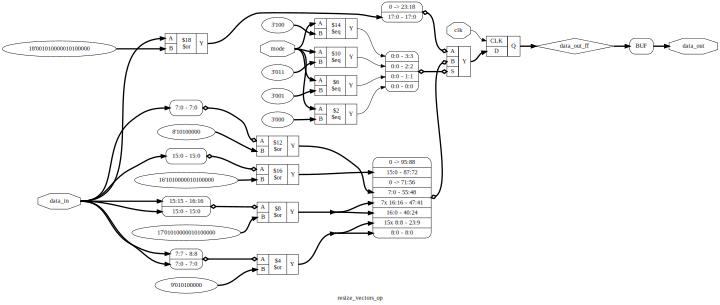

In [3]:
from ys_aux import to_svg

display(to_svg(design))

## Pitfall #1

Earlier synthesis editions and VHDL conversion exposed a pitfall: Extension did not occur based on the signedness of the operands. If either of the operands is treated signed, the result is signed as well and might be interpreted wrongly, assuming that a `.signed()` statement is dominant over the operands. So the question comes up: is the const immediate in [line 20](#resize_vector_op) treated unsigned or *implicitely* signed? Answer: MyHDL treats it correctly as unsigned within simulation. However, a converter might have produced a false result in the past.

The correct implementation is as follows:

For mode `000` and mode `001`, the operands before the binary operator `$or` gate **need to be extended by one bit** in order to correctly perform the operation. This is because the immediate constant is **unsigned** where as the `data_in` signal is treated signed.

### Running the test bench

In [4]:
from ys_aux import clkgen, setupCosimulation

@block
def mapped_wrapper(uut, clk, ce, reset, mode, data_out, data_in):
    "Cosimulation object for yosys post-synthesis(mapping) verilog output"
    args = locals()
    name = uut.__name__ + "_mapped"
    del args['uut']

    return setupCosimulation(name, False, args)

@block
def tb_unit(uut, syn, async_reset, data_in, data_out, IMMEDIATE, DATA):
    mode = Signal(t_lmode.LW)
    clk = Signal(bool())
    debug, debug_syn = [ Signal(bool(0)) for i in range(2) ]
    ce = Signal(bool())
    reset = ResetSignal(0, 1, isasync = async_reset)

    l = len(data_out)
    data_check, data_out_syn = [ Signal(modbv()[l:]) for i in range(2) ]
    
    inst_clkgen = clkgen(clk, 1)

    imm = IMMEDIATE

    inst_uut = uut(clk, mode, data_out, data_in, imm)
    # Synthesized result unit to co-simulate against:
    inst_syn = syn(uut, clk, ce, reset, mode, data_out_syn, data_in)

    @instance
    def stimulus():

        yield delay(4)
        yield clk.negedge

        for c, i in enumerate(DATA):
            m, di, do = i
            data_in.next = di

            mode.next = m

            yield clk.posedge
            data_check.next = do          
            yield clk.negedge            
            
            
            if data_out == do and data_out_syn == do:
                print("Check [%d] OK" % c)
            else:
                print("Check [%d] FAIL" % c)
                print("\n\n")
                print("=========== FAILURE REPORT ============")
                print("Expected output: %x" % do)
                print("Output from simulation: %x" % data_out)
                print("Output from synthesis: %x" % data_out_syn)
                print("========================================")
                raise ValueError("Mismatch: sim: %x, syn: %x" %(data_out, data_out_syn))

                
        raise StopSimulation
        
    return instances()



# Does sign extend:
DATA = [ (t_lmode.LB,  0x80, 0xffffa0), (t_lmode.LH, 0xa001, 0xffa0a1) ]


# Does not sign extend:
DATA += [ (t_lmode.LBU,  0x80, 0xa0), (t_lmode.LHU, 0xa001, 0xa0a1) ]
DATA += [ (t_lmode.LW,  0x8000, 0xa0a0), (t_lmode.LH,  0x80, 0xa0a0)  ]


data_in = Signal(modbv()[SIZE_IN:])
data_out = Signal(modbv()[SIZE_OUT:])

tb = tb_unit(resize_vectors_op, mapped_wrapper, False, data_in, data_out, CONST_IMMEDIATE, DATA)
tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim()
tb.quit_sim()

Check [0] OK
Check [1] OK
Check [2] OK
Check [3] OK
Check [4] OK
Check [5] OK


## Wave trace

A Wave trace dump was created by the above simulation:

In [5]:
import wavedraw
import nbwavedrom

TB = "tb_unit"

cfg = { TB + ".data_in" : None, TB + ".data_out" : None, TB + ".data_check" : None, TB + ".data_out_syn" : None }
cfg[TB + '.mode'] = None

waveform = wavedraw.vcd2wave("tb_unit.vcd", TB + '.clk', cfg)
    
nbwavedrom.draw(waveform)

Compare `data_check` against `data_out_syn`!